In [1]:
import numpy as np
import sys
import time
from casadi import *
import control
from gyrobro_gym_env import GyrobroBulletEnv

from pyMPC import * #MPCController


import vbcontrolpy as vb

pybullet build time: Jul 10 2024 15:33:38


In [2]:
I_THETA = 0
THETA = 1
PSI = 2
D_THETA = 3
D_PSI = 4
PHI = 5
D_PHI = 6

Gyrobro Dynamics

In [3]:
Ts = 0.01
# Physical constants
g = 9.81                        # gravity acceleration [m/sec**2]
# Physical parameters
m = 0.975						# wheel weight [kg]
hw = 0.045                      # wheel width [m]
R = 0.159						# wheel radius [m]

Mstator = 0.548
R_stator = 0.105                # stator radius [m]
hw_stator = 0.025

Jw = (m * R**2 / 2) - (Mstator * R_stator**2 / 2)				# wheel inertia moment [kgm**2]
Jwx = (m * (3*R**2 + hw**2) / 12) - (Mstator * (3*R_stator**2 + hw_stator**2) / 12)   # wheel inertia moment around x and y axes

M = 4.346                       # body weight [kg]
W = 0.37						# body width [m]
D = 0.09					    # body depth [m]
h = 0.4 						# body height [m]
L = h / 2						# distance of the center of mass from the wheel axle [m]
Jpsi = M * L**2 / 3;				# body pitch inertia moment [kgm**2]
Jphi = M * (W**2 + D**2) / 12	    # body yaw inertia moment [kgm**2]
fm = 0.0022					    # friction coefficient between body & DC motor
fw = 0.0063           			    # friction coefficient between wheel & floor

# Motors parameters
Jm = 1e-5						# DC motor inertia moment [kgm**2]
Kt = 2						# DC motor torque constant [Nm/A]
n = 1							# Gear ratio

Psi0 = 0.01                     # Initial value to make disturbance

dim_x = 7
dim_y = 5
dim_u = 2

# MPC Params
n_horizon = 60
max_torq = 5.0
max_psi = 0.3 #np.pi/6
max_u = np.array([max_torq, max_torq])
max_x = np.array([np.inf, np.inf, max_psi, np.inf, np.inf, np.inf, np.inf])
max_du = np.array([np.inf]*2)
# Q_mpc = np.array([
#     [0.001, 0, 0, 0, 0, 0, 0],
#     [0, 0.01, 0, 0, 0, 0, 0],
#     [0, 0, 1, 0, 0, 0, 0],
#     [0, 0, 0, 20, 0, 0, 0],
#     [0, 0, 0, 0, 1, 0, 0],
#     [0, 0, 0, 0, 0, 1, 0],
#     [0, 0, 0, 0, 0, 0, 1]
# ])
Q_mpc = np.array([ [0.00,     0,     0,     0,     0,     0,     0],
                [0,     40,     0,     0,     0,     0,     0],
                [0,     0,     5000,     0,     0,     0,     0],
                [0,     0,     0,     16,    0,     0,     0],
                [0,     0,     0,     0,     100,     0,     0],
                [0,     0,     0,     0,     0,     500,  0],
                [0,     0,     0,     0,     0,     0,     50]]) 
R_du_mpc = np.array([
    [20000, 0],
    [0, 20000]
])

R_u_mpc = np.array([
    [0, 0],
    [0, 0]
])


x0 = np.zeros((dim_x,), dtype=float)
x_cmd = np.zeros((dim_x,), dtype=float)
uminus1 = np.zeros((dim_u,), dtype=float)



In [4]:
alpha = n * Kt
beta = fm
E = np.array ([[(2*m+M)*R**2 + 2*Jw + 2*n**2*Jm,   M*L*R - 2*n**2*Jm],
               [M*L*R - 2*n**2*Jm,                 M*L**2 + Jpsi + 2*n**2*Jm]], dtype=float)
F = np.array ([[beta+fw,   -beta],
                 [-beta,      beta]], dtype=float)*2
G = np.array ([[0,   0],
               [0,  -M*g*L]], dtype=float)
H = np.array ([[alpha,    alpha],
               [-alpha,  -alpha]], dtype=float)
I = m * W**2 / 2 + Jphi + (Jw + n**2 * Jm) * W**2 / (2 * R**2)
J = W**2 / (2 * R**2) * (beta + fw)
K = W / (2 * R) * alpha

In [5]:
A1 = np.array([[0, 0,   1, 0],
	            [0, 0,   0, 1],
               [0, 0,   0, 0],
               [0, 0,   0, 0]], dtype=float)
            #    [-inv(E)*G,  -inv(E)*F]]) 
A1[2:4, 0:2] = np.matmul(-inv(E), G)
A1[2:4, 2:4] = np.matmul(-inv(E), F)

B1 = np.array([[0, 0],
	            [0, 0],
               [0, 0],
			      [0, 0]], dtype=float)
B1[2:4, 0:2] = np.matmul(inv(E), H)
C1 = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [0, 0, 0, 1]], dtype=float)
D1 = np.zeros((4, 2))
A2 = np.array([[0,  1],
	            [0,  -J/I]], dtype=float)
B2 = np.array([[0,    0],
	            [-K/I,  K/I]], dtype=float)
C2 = np.array([[1, 0],
               [0, 1]], dtype=float)
D2 = np.zeros((2,2))

In [6]:
# State space models
s1 = control.ss(A1, B1, C1, D1)
s1.set_states =  ['theta', 'psi', 'theta_dot', 'psi_dot']
s1.set_inputs =  ['il', 'ir']
s1.set_outputs = ['theta', 'psi', 'theta_dot', 'psi_dot']
s2 = control.ss(A2, B2, C2, D2)
s2.set_states(['phi', 'phi_dot'])
s2.set_inputs(['il', 'ir'])
s2.set_outputs(['phi', 'phi_dot'])

# Add a fifth state - integral of theta
s0 = control.tf2ss([1], [1,0])
s0.set_states = 'theta_int'
s0.set_outputs = 'theta_int'
s3 = control.append(s0, s1)
s3.A[0, 1] = 1
s3.B = s3.B[:, 1:]
s3.D = s3.D[:, 1:]
s3.set_inputs(['il', 'ir'])

# Add phi and phi_dot states (from s2 system)
s4 = control.append(s3, s2)
s4.B[-1, 0:2] = s4.B[-1, 2:4]
s4.B = s4.B[:, 0:2]
s4.D = s4.D[:, 0:2]
s4.set_inputs(['il', 'ir'])

# Convert s4 to discrete-time domain
s5 = control.sample_system(s4,Ts, method='bilinear')

Nonlinear Dynamics

In [7]:
def nonlinear_dynamics(x, u):
    alpha = n * Kt #n * Kt / Rm
    beta = fm #n * Kt * Kb / Rm + fm

    F_11 = 2*(beta+fw)
    F_12 = -2*beta
    F_21 = -2*beta
    F_22 = 2*beta

    E_11 = (2*m +M) * R**2 + 2 * Jw + 2*n**2*Jm
    E_12 = M*L*R - 2*n**2*Jm
    E_21 = E_12
    E_22 = M*L**2 + Jpsi + 2*n**2*Jm
    detE = E_11*E_22 - E_12*E_21

    I = 0.5*m*W**2 + Jphi + (W**2/(2*R**2))*(Jw + n**2*Jm)
    J = (W**2/(2*R**2))*(beta + fw)
    K = (W/(2*R))*alpha

    eq4 = -E_12*(-F_21*x[3][0] - F_22*x[4][0] + L**2*M*x[6][0]**2*np.sin(x[2][0])*np.cos(x[2][0]) + L*M*g*np.sin(x[2][0]) + alpha*(-u[0][0] - u[1][0]))/detE + E_22*(-F_11*x[3][0] - F_12*x[4][0] + L*M*R*x[4][0]**2*np.sin(x[2][0]) + alpha*(u[0][0] + u[1][0]))/detE
    eq5 = E_11*(-F_21*x[3][0] - F_22*x[4][0] + L**2*M*x[6][0]**2*np.sin(x[2][0])*np.cos(x[2][0]) + L*M*g*np.sin(x[2][0]) + alpha*(-u[0][0] - u[1][0]))/detE - E_21*(-F_11*x[3][0] - F_12*x[4][0] + L*M*R*x[4][0]**2*np.sin(x[2][0]) + alpha*(u[0][0] + u[1][0]))/detE
    eq6 = (-J*x[6][0] + K*(-u[0][0] + u[1][0]) - 2*L**2*M*x[4][0]*x[6][0]*np.sin(x[2][0])*np.cos(x[2][0]))/I

    state = np.array([
                      [x[0][0] + x[1][0]*Ts], 
                      [x[1][0] + x[3][0]*Ts], 
                      [x[2][0] + x[4][0]*Ts], 
                      [x[3][0] + eq4*Ts], 
                      [x[4][0] + eq5*Ts],
                      [x[5][0] + x[6][0]*Ts], 
                      [x[6][0] + eq6*Ts]
                      ] , dtype=float)
    
    jacobian = np.eye(7)

    jacobian[0][1] = Ts
    jacobian[1][3] = Ts
    jacobian[2][4] = Ts
    jacobian[5][6] = Ts

    jacobian[3][2] = -Ts*L*M*(E_12*(-2*L*state[6][0]**2*np.sin(state[2][0])**2 + L*state[6][0]**2 + g*np.cos(state[2][0])) - E_22*R*state[4][0]**2*np.cos(state[2][0]))/detE
    jacobian[3][3] = (Ts*(E_12*F_21 - E_22*F_11) + detE)/detE
    jacobian[3][4] = Ts*(E_12*F_22 - E_22*(F_12 - 2*L*M*R*state[4][0]*np.sin(state[2][0])))/detE
    jacobian[3][6] = -Ts*E_12*L**2*M*state[6][0]*np.sin(2*state[2][0])/detE
    jacobian[4][2] = Ts*L*M*(E_11*(-2*L*state[6][0]**2*np.sin(state[2][0])**2 + L*state[6][0]**2 + g*np.cos(state[2][0])) - E_21*R*state[4][0]**2*np.cos(state[2][0]))/detE
    jacobian[4][3] = Ts*(-E_11*F_21 + E_21*F_11)/detE
    jacobian[4][4] = (-Ts*(E_11*F_22 - E_21*(F_12 - 2*L*M*R*state[4][0]*np.sin(state[2][0]))) + detE)/detE
    jacobian[4][6] = Ts*E_11*L**2*M*state[6][0]*np.sin(2*state[2][0])/detE

    jacobian[6][2] = -2*Ts*L**2*M*state[4][0]*state[6][0]*np.cos(2*state[2][0])/I
    jacobian[6][4] = -Ts*L**2*M*state[6][0]*np.sin(2*state[2][0])/I
    jacobian[6][6] = (-Ts*(J + L**2*M*state[4][0]*np.sin(2*state[2][0])) + I)/I

    return state, jacobian

Extended Kalman Filter

In [8]:
class ExtendedKalmanFilter():
    def __init__(self, dim_x : int, dim_u : int, dim_z : int) -> None:
        self.H = np.zeros((dim_z, dim_x), dtype=float)
        self.R = np.zeros((dim_z, dim_z), dtype=float)
        self.Q = np.zeros((dim_x, dim_x), dtype=float)
        
        self.P = np.zeros((dim_x, dim_x), dtype=float)
        self.P_ = np.zeros((dim_x, dim_x), dtype=float)

        self.I = np.eye(dim_x)
        self.x_hat = 0
        self.x_ = 0
        self.dfdx = np.zeros((dim_x, dim_x), dtype=float)

    def set_dynamics(self, dynamics):
        self.dynamics = dynamics

    def set_measurement_matrix(self, H):
        self.H = H

    def set_noise(self, R, Q):
        self.R = R
        self.Q = Q

    def set_initial_estimate(self, x0, P0):
        self.x_hat = x0
        self.P = P0

    def predict(self, u):
        self.x_, self.dfdx = self.dynamics(self.x_hat, u)
        self.P_ = self.dfdx @ self.P @ (self.dfdx.T) + self.Q

    def update(self, z):
        # compute the Kalman Gain
        K = self.P_ @ self.H.T @ np.linalg.inv(self.H @ self.P_ @ self.H.T + self.R)
        # update estimate with measurement
        self.x_hat = self.x_ + K @ (z - self.H @ self.x_)
        # update the estimate uncertainty
        self.P = (self.I - K @ self.H) @ self.P_ @ ((self.I - K @ self.H).T) + K @ self.R @ K.T 
        return self.x_hat

    def step(self, z):
        self.predict()
        self.update(z)
        return self.x_hat

In [9]:
# EKF Params

x0_ekf = np.array([[0], [0], [0], [0], [0], [0], [0]], dtype=float)
P0_ekf = np.eye(dim_x) * 0.1
H_ekf = np.array([[0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 1]])
sigma = [2, 
            2, 
            0.05, 
            0.1, 
            0.02]; # variance of measurements [theta psi d_theta d_psi phi d_phi]
Q_ekf = np.array([[Ts**4/4,     Ts**3/2,     0,          Ts**2/2,     0,          0,          0],
                  [Ts**3/2,     10*Ts**2,       0,          Ts,         0,          0,          0],
                  [0,          0,          1,       0,             Ts,         0,          0],
                  [Ts**2/2,     Ts,         0,          1000,        0,          0,          0],
                  [0,          0,          Ts,         0,          100,         0,          0],
                  [0,          0,          0,          0,          0,          100*Ts**2,       Ts],
                  [0,          0,          0,          0,          0,          Ts,         1]])

R_ekf = np.array([[sigma[0],   0,          0,          0,          0],
                  [0,          sigma[1],   0,          0,          0],
                  [0,          0,          sigma[2],   0,          0],
                  [0,          0,          0,          sigma[3],   0],
                  [0,          0,          0,          0,          sigma[4]]])

In [10]:
# create ekf
ekf = ExtendedKalmanFilter(dim_x, dim_u, dim_y)
ekf.set_dynamics(nonlinear_dynamics)
ekf.set_initial_estimate(x0_ekf, P0_ekf)
ekf.set_measurement_matrix(H_ekf)
ekf.set_noise(R_ekf, Q_ekf)

Initialize Simulator

In [11]:
env = GyrobroBulletEnv(render=True, 
                       sim_freq=1/Ts, 
                       on_rack=False,
                     #   real_time=False,
                       initial_pitch=Psi0,
                    #    observation_noise_stdev=[0.0, 0.0, 0.0, 0.0, 0.0])
                       observation_noise_stdev=[0.02, 0.02, 0.005, 0.02, 0.005])

argv[0]=--width=2280
argv[1]=--height=1500
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=4
argv[0] = --unused
argv[1] = --width=2280
argv[2] = --height=1500
argv[3] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3080 Laptop GPU/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 535.183.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 535.183.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3080 Laptop GPU/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation
/home/yoggi/g

Configure MPC

In [12]:
mpc = MPCController(s5.A, s5.B,
                  Np=n_horizon, 
                  x0=x0,
                  xref=x_cmd,
                  uminus1=uminus1,
                  
                  Qx=Q_mpc, 
                  QxN=Q_mpc, 
                  Qu=R_u_mpc,
                  QDu=R_du_mpc,

                  xmin=-max_x,
                  xmax=max_x,
                  umin=-max_u,
                  umax=max_u,
                  Dumin=-max_du,
                  Dumax=max_du)
mpc.setup()
u = uminus1

In [13]:
dim_x = 7
theta_l = 0
theta_r = 0
i_theta = 0
theta = 0
pre_theta = 0
psi = 0
d_theta = 0
d_psi = 0
phi = 0
pre_phi = 0
d_phi = 0

ref_i_theta = 0
ref_theta = 0
ref_d_theta = 0
ref_psi = 0
ref_d_psi = 0
ref_phi = 0
ref_d_phi = 0

x_hat_ekf = np.zeros([dim_x,1])

# data for analysis
ref_lin_vel_vector = []
ref_yaw_vel_vector = []
ref_psi_vector = []
ref_d_psi_vector = []
i_theta_vector = []
lin_veLvector = []
dyaw_vector = []
yaw_vector = []
ref_yaw_vector = []
psi_vector = []
dpsi_vector = []
u_vector = [[],[]]
t_vector = []
theta_vector = []
u_vector = [[],[]]
x_cmd_vector = [[],[],[],[],[],[],[]]
x_sensors_vector = [[],[],[],[],[],[],[]]
x_hat_ekf_vector = [[],[],[],[],[],[],[]]
x_hat_ekf_vector = [[],[],[],[],[],[],[]]
x_hat_ukf_vector = [[],[],[],[],[],[],[]]
ekf_abs_err_vector = [[],[],[],[],[],[],[]]
ekf_abs_err_vector = [[],[],[],[],[],[],[]]
ukf_abs_err_vector = [[],[],[],[],[],[],[]]
t = 0
real_x_vector = [[],[],[],[],[],[],[]]

elapsed_time_vector = []

In [14]:
ref_lin_vel = 0.0
ref_yaw_vel = 1.0

for k in range(2500):
        if k < 330:
                ref_lin_vel = 2.0
                ref_yaw_vel = 0.0
        elif 330 <= k < 660:
                ref_lin_vel = 0.0
                ref_yaw_vel = 0.5
        elif 600 <= k < 1000:
                ref_lin_vel = -2.0
                ref_yaw_vel = 0.0
        elif 1000 <= k < 1300:
                ref_lin_vel = 0.0
                ref_yaw_vel = -0.5
        else:
                ref_lin_vel = 2.0
                ref_yaw_vel = 1.0


        start = time.time()    
        
        # ----------------------
        # u0 = mpc.make_step(x_hat_ekf)
        # ----------------------
        mpc.update(x_hat_ekf.reshape(7,), u, xref=x_cmd)
        u = mpc.output()
        # print(u)
        # ----------------------

        
        end = time.time()

        elapsed_time = end - start
        elapsed_time_vector.append(elapsed_time)
        if k % 2000 == 0:   
                print(f"Average elapsed time: {np.mean(np.array(elapsed_time_vector, dtype=float))}")
                elapsed_time_vector = []
        
        action = [-Kt*u[0], Kt*u[1]]

        obs, rew, done, info = env.step(action)

        # get sensor states
        phi_tmp = ((2*np.pi - obs[5] - pre_phi) % (2*np.pi))
        if phi_tmp > np.pi:
                phi += (phi_tmp - 2*np.pi)
        else:
                phi += phi_tmp
        pre_phi = phi

        theta_l = -obs[0]
        theta_r = obs[1]
        psi = -obs[4]
        d_psi = -obs[6]
        d_phi = -obs[7]

        theta = 0.5 * (theta_l + theta_r) + psi
        i_theta += (theta*Ts)
        d_theta = (theta - pre_theta) / Ts
        pre_theta = theta

        x0 = np.array([[i_theta],
                        [theta],
                        [psi],
                        [d_theta],
                        [d_psi],
                        [phi],
                        [d_phi]], dtype=float)
        
        # set reference state
        ref_d_theta = ref_lin_vel#*np.pi/0.471
        ref_theta += (ref_d_theta*Ts)
        ref_i_theta += (ref_theta*Ts)
        ref_d_psi = 0
        ref_psi = 0
        ref_d_phi = ref_yaw_vel
        ref_phi += (ref_d_phi*Ts)
        x_cmd = np.array([ref_i_theta,
                        ref_theta,
                        ref_psi,
                        ref_d_theta,
                        ref_d_psi,
                        ref_phi,
                        ref_d_phi], dtype=float)
        # x0 = estimator.make_step(y_next)

        # Linear Kalman Filter
        z = np.array([  [theta],
                        [psi],
                        [d_psi],
                        [phi],
                        [d_phi]], dtype=float)
        ekf.predict([[ u[0]], 
                    [-u[1]]])
        x_hat_ekf = ekf.update(z)

        # save data
        for i in range(dim_x):
                x_cmd_vector[i].append(x_cmd[i])
                x_sensors_vector[i].append(x0[i][0])
                x_hat_ekf_vector[i].append(x_hat_ekf[i])
        u_vector[0].append(action[0])
        u_vector[1].append(action[1])

        psi_vector.append(psi)
        t_vector.append(t)
        t += Ts

Average elapsed time: 0.0013468265533447266
Average elapsed time: 0.0009391407966613769


Displaying the Result

In [15]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

Text(0.5, 1.0, '$d\\phi$')

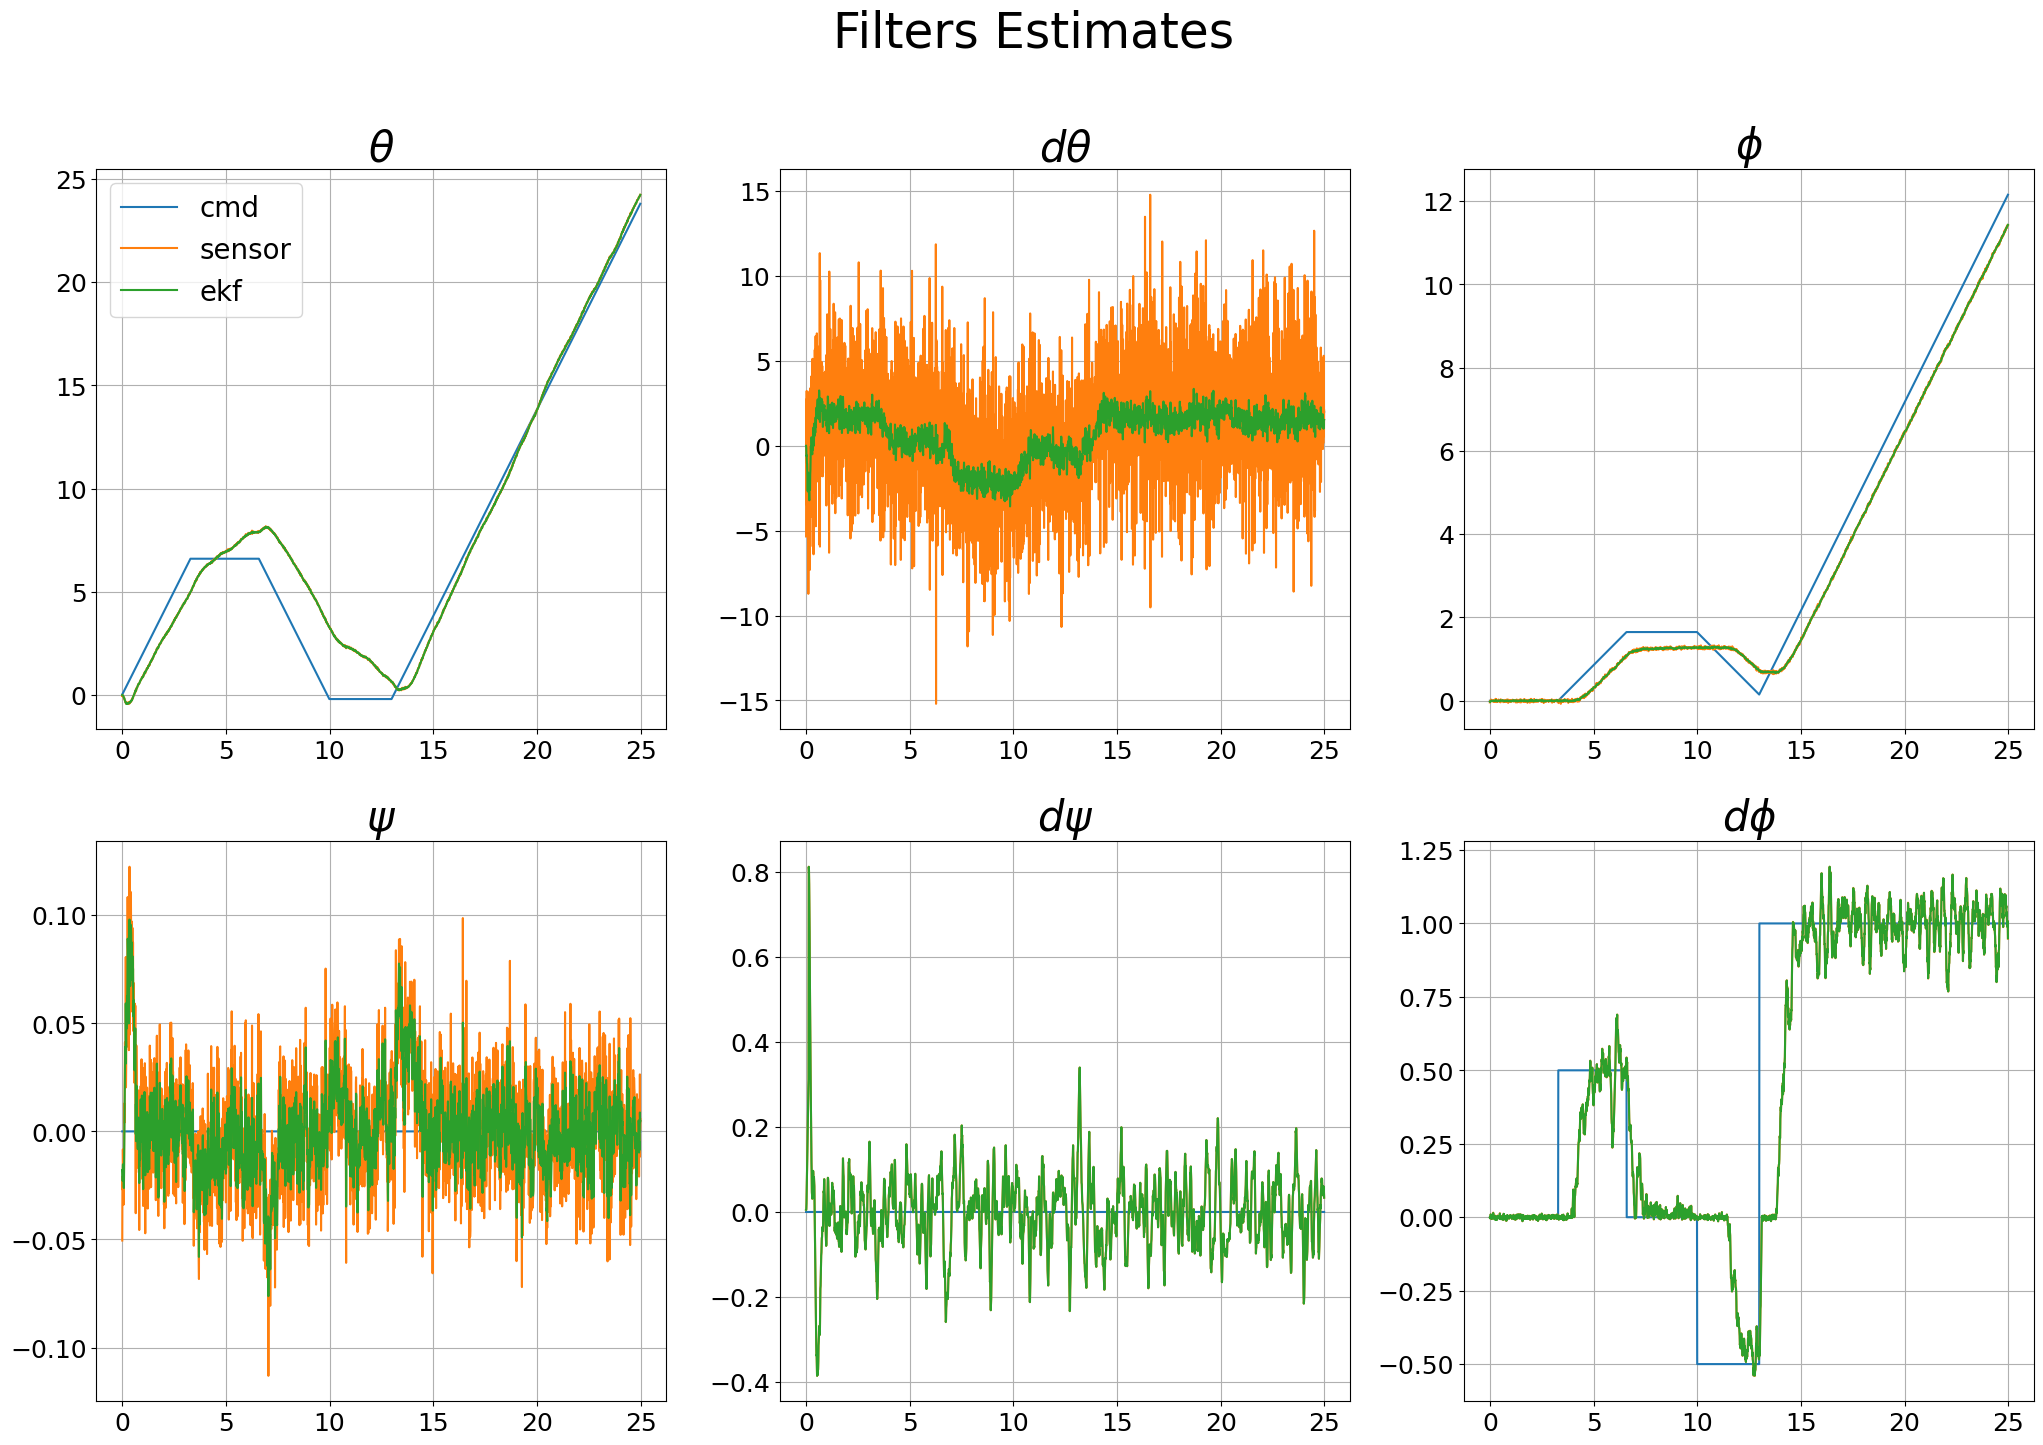

In [16]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 16))
fig.suptitle('Filters Estimates', fontsize="35")

ax1.plot(t_vector, x_cmd_vector[THETA], label="cmd")
ax1.plot(t_vector, x_sensors_vector[THETA], label="sensor")
# ax1.plot(t_vector, real_x_vector[1], label="real")
ax1.plot(t_vector, x_hat_ekf_vector[1], label="ekf")
# ax1.plot(t_vector, x_hat_ekf_vector[1], label="EKF")
# ax1.plot(t_vector, x_hat_ukf_vector[1], label="UKF")
ax1.grid(True)
ax1.set_title(r'$\theta$', fontsize="30")
ax1.legend(fontsize="20")
# ax1.rc('xtick', labelsize=15)

ax2.plot(t_vector, x_cmd_vector[D_THETA], label="cmd")
ax2.plot(t_vector, x_sensors_vector[D_THETA], label="sensor")
# ax2.plot(t_vector, real_x_vector[3], label="real")
ax2.plot(t_vector, x_hat_ekf_vector[3], label="ekf")
# ax2.plot(t_vector, x_hat_ekf_vector[3], label="EKF")
# ax2.plot(t_vector, x_hat_ukf_vector[3], label="UKF")
ax2.grid(True)
ax2.set_title(r'$d\theta$', fontsize="30")

ax3.plot(t_vector, x_cmd_vector[PHI], label="cmd")
ax3.plot(t_vector, x_sensors_vector[PHI], label="sensor")
# ax3.plot(t_vector, real_x_vector[5], label="real")
ax3.plot(t_vector, x_hat_ekf_vector[5], label="ekf")
# ax3.plot(t_vector, x_hat_ekf_vector[5], label="EKF")
# ax3.plot(t_vector, x_hat_ukf_vector[5], label="UKF")
ax3.grid(True)
ax3.set_title(r'$\phi$', fontsize="30")

ax4.plot(t_vector, x_cmd_vector[PSI], label="cmd")
ax4.plot(t_vector, x_sensors_vector[PSI], label="sensor")
# ax4.plot(t_vector, real_x_vector[2], label="real")
ax4.plot(t_vector, x_hat_ekf_vector[2], label="ekf")
# ax4.plot(t_vector, x_hat_ekf_vector[2], label="EKF")
# ax4.plot(t_vector, x_hat_ukf_vector[2], label="UKF")
ax4.grid(True)
ax4.set_title(r'$\psi$', fontsize="30")

ax5.plot(t_vector, x_cmd_vector[D_PSI], label="cmd")
ax5.plot(t_vector, x_sensors_vector[D_PSI], label="sensor")
# ax5.plot(t_vector, real_x_vector[4], label="real")
ax5.plot(t_vector, x_hat_ekf_vector[4], label="ekf")
# ax5.plot(t_vector, x_hat_ekf_vector[4], label="EKF")
# ax5.plot(t_vector, x_hat_ukf_vector[4], label="UKF")
ax5.grid(True)
ax5.set_title(r'$d\psi$', fontsize="30")

ax6.plot(t_vector, x_cmd_vector[D_PHI], label="cmd")
ax6.plot(t_vector, x_sensors_vector[D_PHI], label="sensor")
# ax6.plot(t_vector, real_x_vector[6], label="real")
ax6.plot(t_vector, x_hat_ekf_vector[6], label="ekf")
# ax6.plot(t_vector, x_hat_ekf_vector[6], label="EKF")
# ax6.plot(t_vector, x_hat_ukf_vector[6], label="UKF")
ax6.grid(True)
ax6.set_title(r'$d\phi$', fontsize="30")

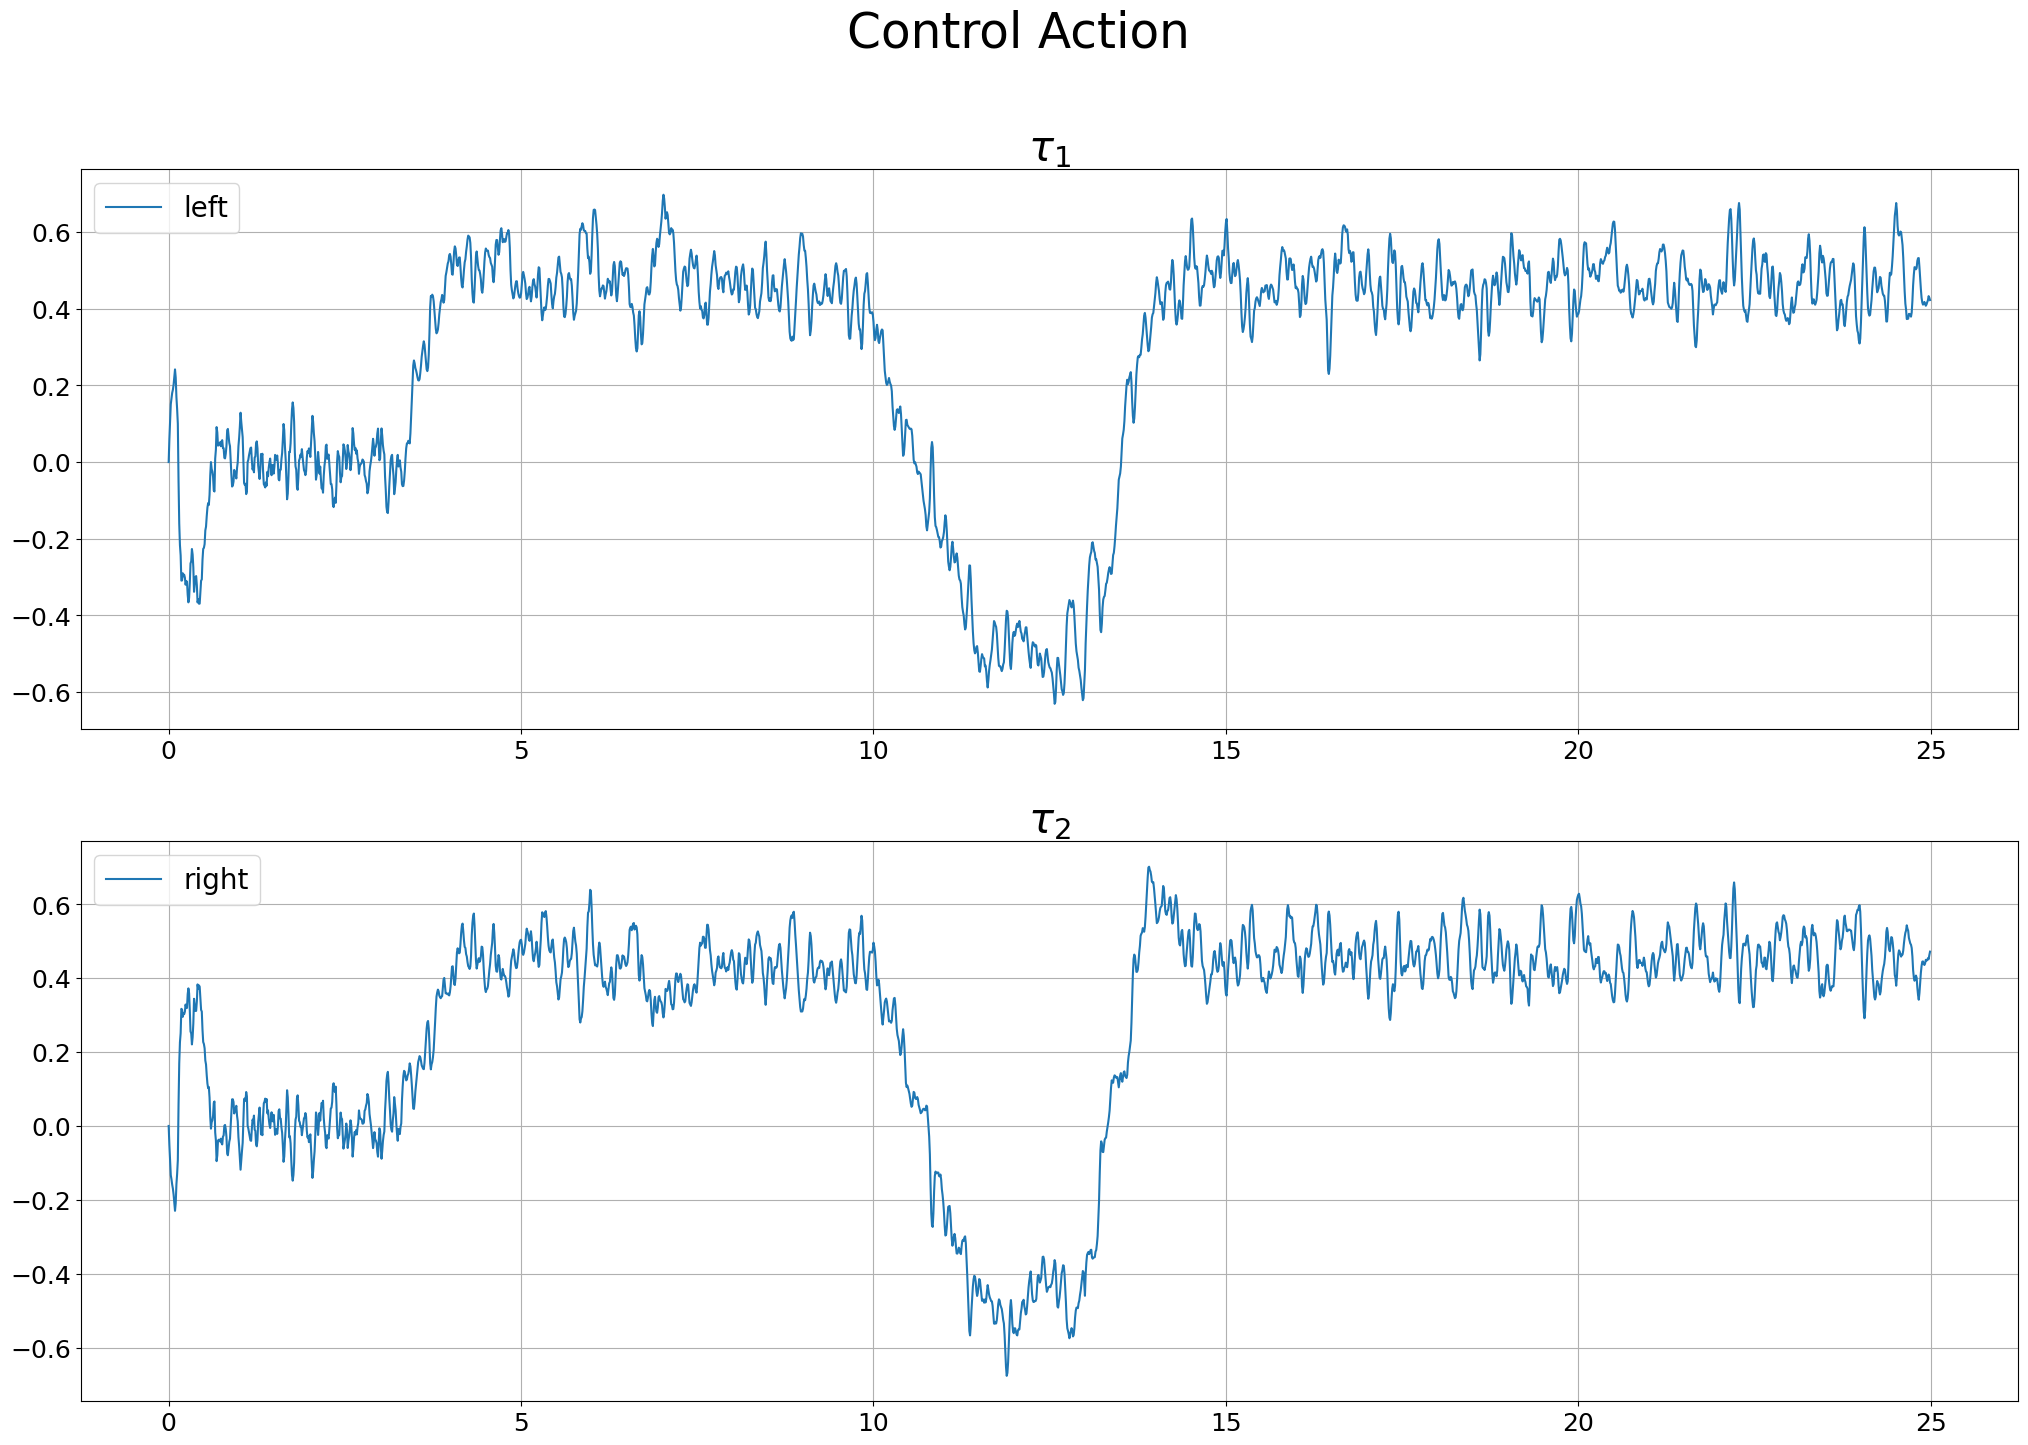

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 16))
fig.suptitle('Control Action', fontsize="35")

ax1.plot(t_vector, u_vector[0], label="left")
ax1.grid(True)
ax1.set_title(r'$\tau_1$', fontsize="30")
ax1.legend(fontsize="20")
# ax1.rc('xtick', labelsize=15)

ax2.plot(t_vector, u_vector[1], label="right")
ax2.grid(True)
ax2.set_title(r'$\tau_2$', fontsize="30")
ax2.legend(fontsize="20")